In [1]:
!pip install split-folders
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 

import zipfile,os
import splitfolders
import numpy as np
from google.colab import files
from keras.preprocessing import image
import keras
import shutil

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
base_dir = '/content/drive/MyDrive/handwriting'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')

# membuat direktori train dan validation
os.mkdir(train_dir)
os.mkdir(validation_dir)

In [4]:
# membuat direktori dyslexia pada direktori data training
train_dysl_dir = os.path.join(train_dir, 'dyslexia')

# membuat direktori normal direktori data training
train_norm_dir = os.path.join(train_dir, 'normal')

# membuat direktori dyslexia pada direktori data validasi
val_dysl_dir = os.path.join(validation_dir, 'dyslexia')

# membuat direktori normal pada direktori data validasi
val_norm_dir = os.path.join(validation_dir, 'normal')

In [5]:
dyslexia_dir = os.path.join(base_dir,'dyslexia')
normal_dir = os.path.join(base_dir, 'normal')

In [6]:
# memisahkan setiap direktori untuk data training dan data validasi (validasi 20%)
train_dyslexia_dir, val_dyslexia_dir = train_test_split(os.listdir(dyslexia_dir), test_size = 0.20)
train_normal_dir, val_normal_dir = train_test_split(os.listdir(normal_dir), test_size = 0.20)

In [7]:
# membuat directory baru di dalam directory train dan val
os.mkdir(train_dysl_dir)
os.mkdir(train_norm_dir)
os.mkdir(val_dysl_dir)
os.mkdir(val_norm_dir)

In [8]:
# meng copy data train dan data val ke directory baru
import shutil

for file in train_dyslexia_dir:
  shutil.copy(os.path.join(dyslexia_dir, file), os.path.join(train_dysl_dir, file))
for file in train_normal_dir:
  shutil.copy(os.path.join(normal_dir,file), os.path.join(train_norm_dir,file))
for file in val_dyslexia_dir:
  shutil.copy(os.path.join(dyslexia_dir,file), os.path.join(val_dysl_dir,file))
for file in val_normal_dir:
  shutil.copy(os.path.join(normal_dir,file), os.path.join(val_norm_dir,file))

In [9]:
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')

val_datagen = ImageDataGenerator(
                    rescale=1./255)

In [10]:
train_generator = train_datagen.flow_from_directory(
        train_dir,  
        target_size=(160, 160),  
        batch_size=4,
        shuffle = True,
        class_mode='binary') 
        
 
validation_generator = train_datagen.flow_from_directory(
        validation_dir, 
        target_size=(160, 160), 
        batch_size=4,
        shuffle = False,
        class_mode='binary')

Found 228 images belonging to 2 classes.
Found 58 images belonging to 2 classes.


In [11]:
from keras.applications.mobilenet_v2 import MobileNetV2

In [12]:
model = keras.models.Sequential()
model.add(MobileNetV2(weights='imagenet',include_top=False,input_shape=(160,160,3)))
model.add(tf.keras.layers.Conv2D(256, (3,3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(2,2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(521, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 conv2d (Conv2D)             (None, 3, 3, 256)         2949376   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 1, 1, 256)        0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                           

In [13]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

In [14]:
class CustomCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.99):
      print("Akurasi Diatas 90%")
      self.model.stop_training = True

In [15]:
history = model.fit(
      train_generator,
      epochs=20,
      validation_data=validation_generator, 
      # validation_steps=4,
      callbacks=[CustomCallback()],  
     )

Epoch 1/20
36/57 [=================>............] - ETA: 2s - loss: 2.2188 - accuracy: 0.5486

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


57/57 [==============================] - 32s 179ms/step - loss: 1.8607 - accuracy: 0.5044 - val_loss: 15.7645 - val_accuracy: 0.5517
Epoch 2/20
57/57 [==============================] - 9s 156ms/step - loss: 0.7793 - accuracy: 0.6623 - val_loss: 6.3480 - val_accuracy: 0.5517
Epoch 3/20
57/57 [==============================] - 9s 156ms/step - loss: 0.6586 - accuracy: 0.7368 - val_loss: 6.5763 - val_accuracy: 0.5690
Epoch 4/20
57/57 [==============================] - 9s 154ms/step - loss: 0.6838 - accuracy: 0.6579 - val_loss: 1.5013 - val_accuracy: 0.6379
Epoch 5/20
57/57 [==============================] - 9s 154ms/step - loss: 0.6211 - accuracy: 0.7061 - val_loss: 3.3022 - val_accuracy: 0.4483
Epoch 6/20
57/57 [==============================] - 9s 153ms/step - loss: 0.6231 - accuracy: 0.7325 - val_loss: 1.4098 - val_accuracy: 0.5690
Epoch 7/20
57/57 [==============================] - 9s 154ms/step - loss: 0.6450 - accuracy: 0.6842 - val_loss: 0.8303 - val_accuracy: 0.7759
Epoch 8/20
57/5

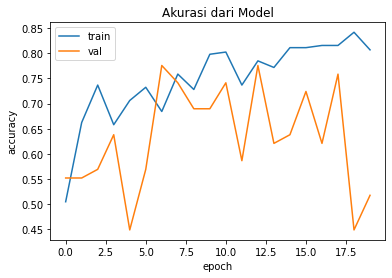

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi dari Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

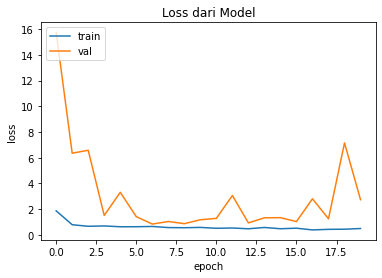

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss dari Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [18]:
#fungsi untuk mendapatkan label indeks hasil deteksi
def get_class_string_from_index(index):
   for class_string, class_index in validation_generator.class_indices.items():
      if class_index == index:
         return class_string

Saving 00000005.jpg to 00000005.jpg
{'dyslexia': 0, 'normal': 1}
dyslexia
Hasil Prediksi: dyslexia

dyslexia:14.64%


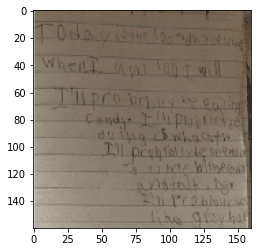

In [19]:
uploaded = files.upload()
lbl=train_generator.class_indices.keys()
print(train_generator.class_indices) 
for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(160,160))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
 
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  predicted_index = np.argmax(classes)
  pr=model.predict(images)[0]
  print(get_class_string_from_index(predicted_index))
  print("Hasil Prediksi: " + get_class_string_from_index(predicted_index))
  print()
  for(l,p) in zip(lbl,pr):
    print("{}:{:.2f}%".format(l,p*100))

In [20]:
model.save("/content/drive/MyDrive/model1.h5")

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [21]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
  
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (160, 160, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False
  
# pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

--2021-12-24 12:17:48--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.197.128, 64.233.191.128, 173.194.74.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.197.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   209MB/s    in 0.4s    

2021-12-24 12:17:48 (209 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

last layer output shape:  (None, 8, 8, 768)


In [22]:
from tensorflow.keras import layers

x = layers.Flatten()(last_output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense  (1, activation='sigmoid')(x)           

model2 = Model( pre_trained_model.input, x) 

model2.compile(optimizer=tf.optimizers.Adam(), 
               loss = 'binary_crossentropy', 
               metrics = ['accuracy'])

In [23]:
history = model2.fit(
      train_generator,    
      epochs=25,
      validation_data=validation_generator, 
      # validation_steps=4, 
     )

Epoch 1/25
43/57 [=====================>........] - ETA: 1s - loss: 2.8462 - accuracy: 0.5640

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


57/57 [==============================] - 15s 185ms/step - loss: 2.4244 - accuracy: 0.6096 - val_loss: 1.1154 - val_accuracy: 0.8276
Epoch 2/25
57/57 [==============================] - 9s 151ms/step - loss: 0.6738 - accuracy: 0.8289 - val_loss: 0.9698 - val_accuracy: 0.7069
Epoch 3/25
57/57 [==============================] - 9s 151ms/step - loss: 0.6069 - accuracy: 0.8289 - val_loss: 0.8962 - val_accuracy: 0.7241
Epoch 4/25
57/57 [==============================] - 9s 148ms/step - loss: 0.5179 - accuracy: 0.8596 - val_loss: 0.9655 - val_accuracy: 0.7414
Epoch 5/25
57/57 [==============================] - 9s 151ms/step - loss: 0.3381 - accuracy: 0.8816 - val_loss: 0.6623 - val_accuracy: 0.7586
Epoch 6/25
57/57 [==============================] - 9s 152ms/step - loss: 0.1808 - accuracy: 0.9342 - val_loss: 0.6696 - val_accuracy: 0.7931
Epoch 7/25
57/57 [==============================] - 9s 150ms/step - loss: 0.1739 - accuracy: 0.9167 - val_loss: 0.7555 - val_accuracy: 0.7414
Epoch 8/25
57/57

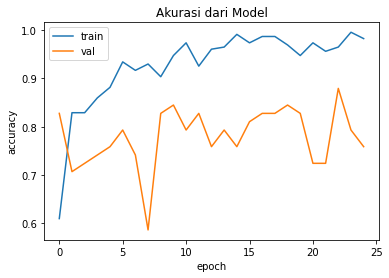

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi dari Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

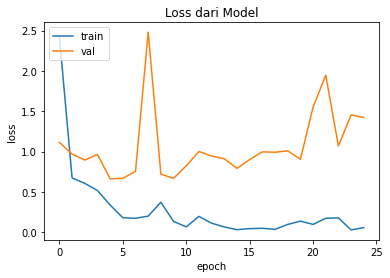

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss dari Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Saving 00000005.jpg to 00000005 (1).jpg
{'dyslexia': 0, 'normal': 1}
dyslexia
Hasil Prediksi: dyslexia


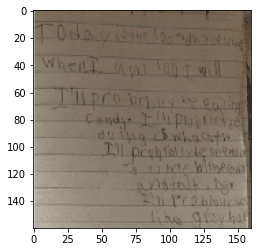

In [26]:
uploaded = files.upload()
print(train_generator.class_indices) 
for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(160,160))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
 
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  predicted_index = np.argmax(classes)
  print(get_class_string_from_index(predicted_index))
  print("Hasil Prediksi: " + get_class_string_from_index(predicted_index))

In [27]:
model2.save("/content/drive/MyDrive/model.h5")